# Customer segmentation

In [140]:
import pyod
from pyod.models.ecod import ECOD
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from kmodes.kprototypes import KPrototypes
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## Create Synthetic Datasets

In [113]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of samples
num_samples = 2000

# Generate user_id
user_id = np.arange(1, num_samples + 1)

# Generate age with a Gaussian distribution
age = np.random.normal(loc=30, scale=10, size=num_samples).astype(int)
age = np.clip(age, 18, 85)

# Generate gender
gender = np.random.choice(['male', 'female'], size=num_samples)

# Generate location
location = np.random.choice(['Bogota', 'Medellin', 'Cartagena', 'Cali', 'Barranquilla'], size=num_samples)

# Generate loan_orig_dt
start_date = datetime(2022, 1, 1)
end_date = datetime.today()
loan_orig_dt = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days)) for _ in range(num_samples)]

# Generate loan_type
loan_type = np.random.choice(['auto', 'mortgage', 'business', 'personal'], size=num_samples)

# Generate credit score with a Gaussian distribution
credit_score = np.random.normal(loc=600, scale=100, size=num_samples).astype(int)
credit_score = np.clip(credit_score, 350, 850)

# Generate account_open status (85% true)
account_open = np.random.choice([True, False], size=num_samples, p=[0.98, 0.02])

# Define income ranges based on location
income_means = {
    'Bogota': 50000000,  # Mean annual income in Colombian pesos for each city
    'Medellin': 45000000,
    'Cartagena': 40000000,
    'Cali': 42000000,
    'Barranquilla': 38000000
}
income_std_dev = 10000000  # Standard deviation for income

# Generate income based on location
income = []
for loc in location:
    income.append(np.random.normal(loc=income_means[loc], scale=income_std_dev))
income = np.array(income)

# Define loan amount ranges based on income
loan_multiplier = {
    'auto': 0.5,  # Auto loan typically half of annual income
    'mortgage': 3,  # Mortgage typically three times the annual income
    'business': 1.5,  # Business loan typically 1.5 times the annual income
    'personal': 0.2  # Personal loan typically one-fifth of annual income
}

# Generate loan_orig_amt based on type of loan and income
loan_orig_amt = []
for i in range(num_samples):
    loan_type_value = loan_type[i]
    user_income = income[i]
    loan_orig_amt.append(np.random.normal(loc=user_income * loan_multiplier[loan_type_value], scale=income_std_dev * loan_multiplier[loan_type_value]))
loan_orig_amt = np.array(loan_orig_amt)

# Generate number_of_installments with variation for different types of loans
number_of_installments = []
for i in range(num_samples):
    loan_type_value = loan_type[i]
    if loan_type_value == 'auto':
        number_of_installments.append(np.random.randint(12, 60))  # 1-5 years
    elif loan_type_value == 'mortgage':
        number_of_installments.append(np.random.randint(120, 360))  # 10-30 years
    elif loan_type_value == 'business':
        number_of_installments.append(np.random.randint(24, 120))  # 2-10 years
    else:  # personal loan
        number_of_installments.append(np.random.randint(12, 48))  # 1-4 years
number_of_installments = np.array(number_of_installments)

# Generate installment_amt
installment_amt = loan_orig_amt / number_of_installments

# Calculate the number of months between loan_orig_dt and the current month
months_since_loan = [(datetime.today() - dt).days // 30 for dt in loan_orig_dt]

# Generate installments_paid
installments_paid = [np.random.randint(0, months + 1) for months in months_since_loan]

# Generate on_time_payments
on_time_payments = [max(0, np.random.binomial(paid, 0.8)) for paid in installments_paid]

# Generate late_payments
late_payments = [paid - on_time for paid, on_time in zip(installments_paid, on_time_payments)]

# Generate account_delq
account_delq = [(late > 0 and np.random.rand() < 0.1) for late in late_payments]

# Generate payment_date (random int between 1 and 28)
payment_date = [np.random.randint(1, 29) for _ in range(num_samples)]


# Create DataFrame
data = pd.DataFrame({
    'user_id': user_id,
    'age': age,
    'gender': gender,
    'location': location,
    'income': income,
    'credit_score': credit_score,
    'account_open': account_open,
    'loan_type': loan_type,
    'loan_orig_dt': loan_orig_dt,
    'loan_orig_amt': loan_orig_amt,
    'number_of_installments': number_of_installments,
    'installment_amt': installment_amt,
    'installments_paid': installments_paid,
    'on_time_payments': on_time_payments,
    'late_payments': late_payments,
    'account_delq': account_delq,
    'payment_date': payment_date
})

#make one age observation missing
data.loc[0, 'age'] = np.nan

#replace one credit score wih 1600
data.loc[1, 'credit_score'] = 1600

data.head(15)


,user_id,age,gender,location,income,credit_score,account_open,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq,payment_date
0,1,NaN,female,Cartagena,5.133063e+07,656,False,mortgage,2024-06-26,1.561560e+08,351,4.448890e+05,0,0,0,False,9
1,2,28.0,male,Cali,4.344222e+07,1600,True,mortgage,2023-08-25,1.997686e+08,259,7.713074e+05,7,6,1,False,21
2,3,36.0,female,Barranquilla,2.619985e+07,567,True,business,2022-12-23,5.114634e+07,102,5.014347e+05,9,7,2,False,26
3,4,45.0,male,Medellin,5.530385e+07,359,True,auto,2022-09-13,2.789891e+07,26,1.073035e+06,6,4,2,False,10
4,5,27.0,male,Cartagena,5.725039e+07,463,True,auto,2022-12-19,2.517500e+07,28,8.991070e+05,16,11,5,False,4
5,6,27.0,female,Cali,4.694705e+07,489,True,mortgage,2024-01-02,1.375160e+08,153,8.987971e+05,3,3,0,False,22
6,7,45.0,male,Cali,5.091290e+07,610,True,business,2023-06-05,7.861681e+07,58,1.355462e+06,6,6,0,False,4
7,8,37.0,female,Bogota,6.220783e+07,633,True,personal,2023-06-08,1.537243e+07,25,6.148970e+05,10,9,1,False,6
8,9,25.0,female,Bogota,3.343395e+07,594,True,mortgage,2024-04-16,1.371016e+08,302,4.539790e+05,3,3,0,False,26
9,10,35.0,male,Medellin,6.364270e+07,561,True,personal,2024-01-26,1.363152e+07,16,8.519699e+05,2,1,1,False,8


In [114]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of samples
num_samples = 999

# Generate user_id
user_id = np.arange(1, num_samples + 1)

# Generate age with a Gaussian distribution with a loc of 20 for the first third of the samples, 30 for the second third, and 40 for the last third
age = np.concatenate([
    np.random.normal(loc=20, scale=5, size=num_samples // 3).astype(int),
    np.random.normal(loc=40, scale=5, size=num_samples // 3).astype(int),
    np.random.normal(loc=60, scale=5, size=num_samples // 3).astype(int)
])
# age = np.random.normal(loc=20, scale=5, size=num_samples).astype(int)
age = np.clip(age, 18, 85)

# Generate gender
gender = np.random.choice(['male', 'female'], size=num_samples)

# Generate location
location = np.random.choice(['Bogota', 'Medellin', 'Cartagena', 'Cali', 'Barranquilla'], size=num_samples)

# Generate loan_orig_dt
start_date = datetime(2022, 1, 1)
end_date = datetime.today()
loan_orig_dt = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days)) for _ in range(num_samples)]

# Generate loan_type
loan_type = np.random.choice(['auto', 'mortgage', 'business', 'personal'], size=num_samples)

# Generate credit score with a Gaussian distribution
credit_score = np.concatenate([
    np.random.normal(loc=450, scale=100, size=num_samples // 3).astype(int),
    np.random.normal(loc=600, scale=100, size=num_samples // 3).astype(int),
    np.random.normal(loc=750, scale=100, size=num_samples // 3).astype(int)
])
credit_score = np.clip(credit_score, 350, 850)

# Generate account_open status (85% true)
account_open = np.random.choice([True, False], size=num_samples, p=[0.98, 0.02])

# Define income ranges based on location
income_means_low = {
    'Bogota': 30000000,  # Mean annual income in Colombian pesos for each city
    'Medellin': 25000000,
    'Cartagena': 20000000,
    'Cali': 22000000,
    'Barranquilla': 18000000
}
income_means_med = {
    'Bogota': 50000000,  # Mean annual income in Colombian pesos for each city
    'Medellin': 45000000,
    'Cartagena': 40000000,
    'Cali': 42000000,
    'Barranquilla': 38000000
}
income_means_high = {
    'Bogota': 70000000,  # Mean annual income in Colombian pesos for each city
    'Medellin': 65000000,
    'Cartagena': 60000000,
    'Cali': 62000000,
    'Barranquilla': 58000000
}
income_std_dev = 10000000  # Standard deviation for income

# Generate income based on location  
income = []
#for the first third of location 
for loc in location[:num_samples // 3]:
    income.append(np.random.normal(loc=income_means_low[loc], scale=income_std_dev))
#for the second third of location
for loc in location[num_samples // 3: 2 * num_samples // 3]:
    income.append(np.random.normal(loc=income_means_med[loc], scale=income_std_dev))
#for the last third of location
for loc in location[2 * num_samples // 3:]:
    income.append(np.random.normal(loc=income_means_high[loc], scale=income_std_dev))

income = np.array(income)

# Define loan amount ranges based on income
loan_multiplier = {
    'auto': 0.5,  # Auto loan typically half of annual income
    'mortgage': 3,  # Mortgage typically three times the annual income
    'business': 1.5,  # Business loan typically 1.5 times the annual income
    'personal': 0.2  # Personal loan typically one-fifth of annual income
}

# Generate loan_orig_amt based on type of loan and income
loan_orig_amt = []
for i in range(num_samples):
    loan_type_value = loan_type[i]
    user_income = income[i]
    loan_orig_amt.append(np.random.normal(loc=user_income * loan_multiplier[loan_type_value], scale=income_std_dev * loan_multiplier[loan_type_value]))
loan_orig_amt = np.array(loan_orig_amt)

# Generate number_of_installments with variation for different types of loans
number_of_installments = []
for i in range(num_samples):
    loan_type_value = loan_type[i]
    if loan_type_value == 'auto':
        number_of_installments.append(np.random.randint(12, 60))  # 1-5 years
    elif loan_type_value == 'mortgage':
        number_of_installments.append(np.random.randint(120, 360))  # 10-30 years
    elif loan_type_value == 'business':
        number_of_installments.append(np.random.randint(24, 120))  # 2-10 years
    else:  # personal loan
        number_of_installments.append(np.random.randint(12, 48))  # 1-4 years
number_of_installments = np.array(number_of_installments)

# Generate installment_amt
installment_amt = loan_orig_amt / number_of_installments

# Calculate the number of months between loan_orig_dt and the current month
months_since_loan = [(datetime.today() - dt).days // 30 for dt in loan_orig_dt]

# Generate installments_paid
installments_paid = [np.random.randint(0, months + 1) for months in months_since_loan]

# Generate on_time_payments
on_time_payments = [max(0, np.random.binomial(paid, 0.8)) for paid in installments_paid]

# Generate late_payments
late_payments = [paid - on_time for paid, on_time in zip(installments_paid, on_time_payments)]

# Generate account_delq
account_delq = [(late > 0 and np.random.rand() < 0.1) for late in late_payments]

# Generate payment_date (random int between 1 and 28)
payment_date = [np.random.randint(1, 29) for _ in range(num_samples)]


# Create DataFrame
data = pd.DataFrame({
    'user_id': user_id,
    'age': age,
    'gender': gender,
    'location': location,
    'income': income,
    'credit_score': credit_score,
    'account_open': account_open,
    'loan_type': loan_type,
    'loan_orig_dt': loan_orig_dt,
    'loan_orig_amt': loan_orig_amt,
    'number_of_installments': number_of_installments,
    'installment_amt': installment_amt,
    'installments_paid': installments_paid,
    'on_time_payments': on_time_payments,
    'late_payments': late_payments,
    'account_delq': account_delq,
    'payment_date': payment_date
})

#make one age observation missing
data.loc[0, 'age'] = np.nan

#replace one credit score wih 1600
data.loc[1, 'credit_score'] = 1600

data.head(15)


,user_id,age,gender,location,income,credit_score,account_open,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq,payment_date
0,1,NaN,male,Cartagena,1.281110e+07,507,True,mortgage,2022-01-12,8.131703e+07,209,3.890767e+05,27,23,4,False,5
1,2,19.0,female,Bogota,3.204069e+07,1600,True,business,2023-09-23,4.827584e+07,75,6.436778e+05,2,1,1,False,9
2,3,23.0,male,Barranquilla,1.095391e+07,389,True,business,2024-07-15,3.128712e+07,31,1.009262e+06,0,0,0,False,9
3,4,27.0,female,Cartagena,1.203342e+07,488,True,personal,2022-10-17,1.958739e+06,27,7.254588e+04,20,17,3,False,2
4,5,18.0,male,Cartagena,1.859802e+07,350,True,business,2024-04-29,2.056685e+07,64,3.213570e+05,3,3,0,False,2
5,6,18.0,male,Bogota,4.263761e+07,386,True,business,2024-01-30,4.576458e+07,26,1.760176e+06,3,3,0,False,19
6,7,27.0,male,Barranquilla,2.545445e+07,357,True,auto,2022-12-20,1.634663e+07,43,3.801542e+05,17,15,2,False,23
7,8,23.0,male,Cali,2.177422e+07,464,True,personal,2023-10-01,6.013287e+06,16,3.758304e+05,4,4,0,False,27
8,9,18.0,female,Barranquilla,2.581186e+07,507,True,mortgage,2022-03-16,6.039891e+07,331,1.824740e+05,21,19,2,False,3
9,10,22.0,male,Medellin,2.768619e+07,524,True,business,2024-05-22,4.555078e+07,37,1.231102e+06,1,1,0,False,17


In [115]:
data.dtypes

user_id                            int64
age                              float64
gender                            object
location                          object
income                           float64
credit_score                       int64
account_open                        bool
loan_type                         object
loan_orig_dt              datetime64[ns]
loan_orig_amt                    float64
number_of_installments             int64
installment_amt                  float64
installments_paid                  int64
on_time_payments                   int64
late_payments                      int64
account_delq                        bool
payment_date                       int64
dtype: object

## Data Cleaning - User Data

### Duplicates
We will want to drop duplicate values. It is important to think about if in your data you want to consider two records duplicates  if they are exactly the same, or if you want to consider them duplicates if they are the same in some subset of columns.

In [116]:
data = data.drop_duplicates().reset_index(drop=True)

### Irrelevant Columns and Observations

Drop irrelevant observations and columns, e.g. drop columns where account_status is False which means closed, and drop type_of_vehicle


In [117]:
data = data[data['account_open'] == True].drop(columns=['payment_date', 'account_open'])

### Missing Values

Investigate missing values 

In [118]:
print(data.isnull().sum())

user_id                   0
age                       1
gender                    0
location                  0
income                    0
credit_score              0
loan_type                 0
loan_orig_dt              0
loan_orig_amt             0
number_of_installments    0
installment_amt           0
installments_paid         0
on_time_payments          0
late_payments             0
account_delq              0
dtype: int64


Several options to handle  missings: if you have a lot of data and only a few missings, you can drop them, 
otherwise you can impute the missings in several ways including using the mean, median, or mode, you could draw a random value from the distribution, 
or you could use a machine learning model to predict the missing value. I am simply going to fill the missing values in age with the mean.

In [119]:
print(data.shape)
data = data.dropna()
print(data.shape)

(978, 15)
(977, 15)


### Outliers



In [120]:
data['credit_score'].describe()

count     977.000000
mean      598.542477
std       153.890371
min       350.000000
25%       472.000000
50%       599.000000
75%       720.000000
max      1600.000000
Name: credit_score, dtype: float64

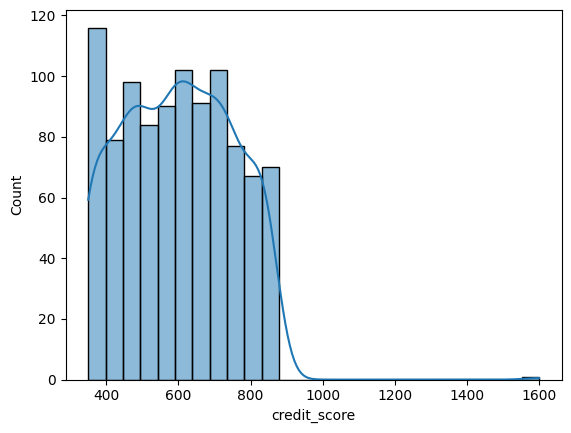

In [121]:
#plot the distribution of credit score as histogram
sns.histplot(data['credit_score'], kde=True)
plt.show()

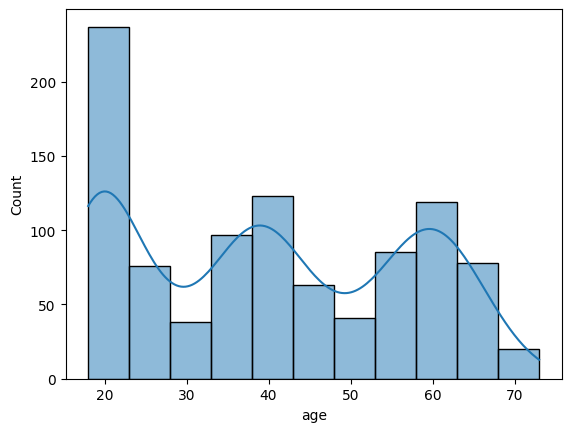

In [122]:
#plot the distribution of age as histogram
sns.histplot(data['age'], kde=True)
plt.show()

In [123]:
#calculate outliers using 3 sd for credit score
for var in ['credit_score', 'age']:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = (data[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,data['outliers'].sum(), "outlier(s).")

The variable credit_score has 1 outlier(s).
The variable age has 0 outlier(s).


In [124]:
#Lets go ahead and just drop these observations as they are only a few observations. 
print("Data has", data.shape[0], "observations to begin.")
data['outliers'] = False
for var in ['credit_score', 'age']:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = data['outliers'] | ((data[var] - mean).abs() > 3*sd)
#drop outliers
data = data[data['outliers'] == False].drop(columns=['outliers'])
print("Data now has", data.shape[0], "observations after dropping the outliers .")

Data has 977 observations to begin.
Data now has 976 observations after dropping the outliers .


## Feature Engineering

In [125]:
data.head()

,user_id,age,gender,location,income,credit_score,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq
2,3,23.0,male,Barranquilla,1.095391e+07,389,business,2024-07-15,3.128712e+07,31,1.009262e+06,0,0,0,False
3,4,27.0,female,Cartagena,1.203342e+07,488,personal,2022-10-17,1.958739e+06,27,7.254588e+04,20,17,3,False
4,5,18.0,male,Cartagena,1.859802e+07,350,business,2024-04-29,2.056685e+07,64,3.213570e+05,3,3,0,False
5,6,18.0,male,Bogota,4.263761e+07,386,business,2024-01-30,4.576458e+07,26,1.760176e+06,3,3,0,False
6,7,27.0,male,Barranquilla,2.545445e+07,357,auto,2022-12-20,1.634663e+07,43,3.801542e+05,17,15,2,False


In [126]:
# extract the object columns
obj_cols = data.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([data, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
df_encoded.head()

,user_id,age,income,credit_score,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,...,gender_male,location_Barranquilla,location_Bogota,location_Cali,location_Cartagena,location_Medellin,loan_type_auto,loan_type_business,loan_type_mortgage,loan_type_personal
2,3.0,23.0,1.095391e+07,389.0,2024-07-15,3.128712e+07,31.0,1.009262e+06,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4.0,27.0,1.203342e+07,488.0,2022-10-17,1.958739e+06,27.0,7.254588e+04,20.0,17.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,18.0,1.859802e+07,350.0,2024-04-29,2.056685e+07,64.0,3.213570e+05,3.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,6.0,18.0,4.263761e+07,386.0,2024-01-30,4.576458e+07,26.0,1.760176e+06,3.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,7.0,27.0,2.545445e+07,357.0,2022-12-20,1.634663e+07,43.0,3.801542e+05,17.0,15.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [127]:
# Standardize the data
df_encoded_scaled = df_encoded.copy()
scaler = StandardScaler()
df_encoded_scaled[['age', 'income', 'credit_score', 'loan_orig_amt', 'number_of_installments', 'installment_amt', 'installments_paid', 'on_time_payments', 'late_payments']] = scaler.fit_transform(df_encoded_scaled[['age', 'income', 'credit_score', 'loan_orig_amt', 'number_of_installments', 'installment_amt', 'installments_paid', 'on_time_payments', 'late_payments']])
df_encoded_scaled.head()

,user_id,age,income,credit_score,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,...,gender_male,location_Barranquilla,location_Bogota,location_Cali,location_Cartagena,location_Medellin,loan_type_auto,loan_type_business,loan_type_mortgage,loan_type_personal
2,3.0,-1.027664,-1.652721,-1.385388,2024-07-15,-0.415392,-0.672273,0.525113,-1.115809,-1.106885,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4.0,-0.785832,-1.597604,-0.727630,2022-10-17,-0.894083,-0.716107,-1.046739,1.745164,1.930733,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,-1.329955,-1.262427,-1.644505,2024-04-29,-0.590366,-0.310643,-0.629222,-0.686663,-0.570835,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,6.0,-1.329955,-0.035007,-1.405320,2024-01-30,-0.179094,-0.727065,1.785181,-0.686663,-0.570835,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,7.0,-0.785832,-0.912349,-1.597997,2022-12-20,-0.659247,-0.540771,-0.530558,1.316018,1.573366,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [128]:
data.head()

,user_id,age,gender,location,income,credit_score,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq
2,3,23.0,male,Barranquilla,1.095391e+07,389,business,2024-07-15,3.128712e+07,31,1.009262e+06,0,0,0,False
3,4,27.0,female,Cartagena,1.203342e+07,488,personal,2022-10-17,1.958739e+06,27,7.254588e+04,20,17,3,False
4,5,18.0,male,Cartagena,1.859802e+07,350,business,2024-04-29,2.056685e+07,64,3.213570e+05,3,3,0,False
5,6,18.0,male,Bogota,4.263761e+07,386,business,2024-01-30,4.576458e+07,26,1.760176e+06,3,3,0,False
6,7,27.0,male,Barranquilla,2.545445e+07,357,auto,2022-12-20,1.634663e+07,43,3.801542e+05,17,15,2,False


In [129]:
#standard scale variables
data_scaled = data.copy()
scaler = StandardScaler()
data_scaled[['age', 'income', 'credit_score', 'loan_orig_amt', 'number_of_installments', 'installment_amt', 'installments_paid', 'on_time_payments', 'late_payments']] = scaler.fit_transform(data_scaled[['age', 'income', 'credit_score', 'loan_orig_amt', 'number_of_installments', 'installment_amt', 'installments_paid', 'on_time_payments', 'late_payments']])
data_scaled.head()


,user_id,age,gender,location,income,credit_score,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq
2,3,-1.027664,male,Barranquilla,-1.652721,-1.385388,business,2024-07-15,-0.415392,-0.672273,0.525113,-1.115809,-1.106885,-0.855800,False
3,4,-0.785832,female,Cartagena,-1.597604,-0.727630,personal,2022-10-17,-0.894083,-0.716107,-1.046739,1.745164,1.930733,0.743296,False
4,5,-1.329955,male,Cartagena,-1.262427,-1.644505,business,2024-04-29,-0.590366,-0.310643,-0.629222,-0.686663,-0.570835,-0.855800,False
5,6,-1.329955,male,Bogota,-0.035007,-1.405320,business,2024-01-30,-0.179094,-0.727065,1.785181,-0.686663,-0.570835,-0.855800,False
6,7,-0.785832,male,Barranquilla,-0.912349,-1.597997,auto,2022-12-20,-0.659247,-0.540771,-0.530558,1.316018,1.573366,0.210264,False


In [130]:
#drop the user_id column
data_for_clustering_means = df_encoded.drop(columns=['user_id', 'loan_orig_dt', 'number_of_installments', 'on_time_payments'])
data_for_clustering_prototype = data_scaled.drop(columns=['user_id', 'loan_orig_dt','number_of_installments', 'on_time_payments'])

In [131]:
data_for_clustering_prototype.head()

,age,gender,location,income,credit_score,loan_type,loan_orig_amt,installment_amt,installments_paid,late_payments,account_delq
2,-1.027664,male,Barranquilla,-1.652721,-1.385388,business,-0.415392,0.525113,-1.115809,-0.855800,False
3,-0.785832,female,Cartagena,-1.597604,-0.727630,personal,-0.894083,-1.046739,1.745164,0.743296,False
4,-1.329955,male,Cartagena,-1.262427,-1.644505,business,-0.590366,-0.629222,-0.686663,-0.855800,False
5,-1.329955,male,Bogota,-0.035007,-1.405320,business,-0.179094,1.785181,-0.686663,-0.855800,False
6,-0.785832,male,Barranquilla,-0.912349,-1.597997,auto,-0.659247,-0.530558,1.316018,0.210264,False


## K-means

In [142]:
data_for_clustering_means.head()

,age,income,credit_score,loan_orig_amt,installment_amt,installments_paid,late_payments,account_delq,gender_female,gender_male,location_Barranquilla,location_Bogota,location_Cali,location_Cartagena,location_Medellin,loan_type_auto,loan_type_business,loan_type_mortgage,loan_type_personal
2,23.0,1.095391e+07,389.0,3.128712e+07,1.009262e+06,0.0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,27.0,1.203342e+07,488.0,1.958739e+06,7.254588e+04,20.0,3.0,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,18.0,1.859802e+07,350.0,2.056685e+07,3.213570e+05,3.0,0.0,False,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,18.0,4.263761e+07,386.0,4.576458e+07,1.760176e+06,3.0,0.0,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,27.0,2.545445e+07,357.0,1.634663e+07,3.801542e+05,17.0,2.0,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [144]:
#drop Nas
data_for_clustering_means = data_for_clustering_means.dropna()

{2: 0.6141126532229001, 3: 0.5724624560551778, 4: 0.4297878045922984, 5: 0.44840054303693144, 6: 0.45293629540957375, 7: 0.4388655364679022, 8: 0.3912181328469422, 9: 0.39261841446864737, 10: 0.36891000623092934}


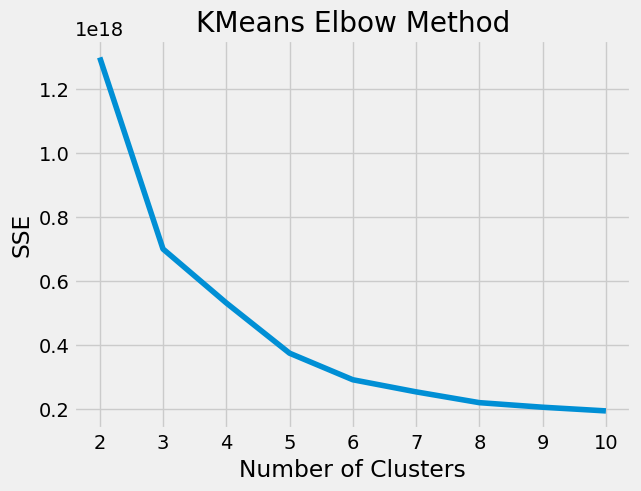

In [145]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
sse = []
silhouette_avg = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data_for_clustering_means)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data_for_clustering_means, cluster_labels)
print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("KMeans Elbow Method")
plt.show()

## K-Prototype

In [132]:
data_for_clustering_prototype.dtypes

age                  float64
gender                object
location              object
income               float64
credit_score         float64
loan_type             object
loan_orig_amt        float64
installment_amt      float64
installments_paid    float64
late_payments        float64
account_delq            bool
dtype: object

### Elbow Graph

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 7777.046062158556
Init: initializing centroids
Init: initializing clusters
Starting iterations..

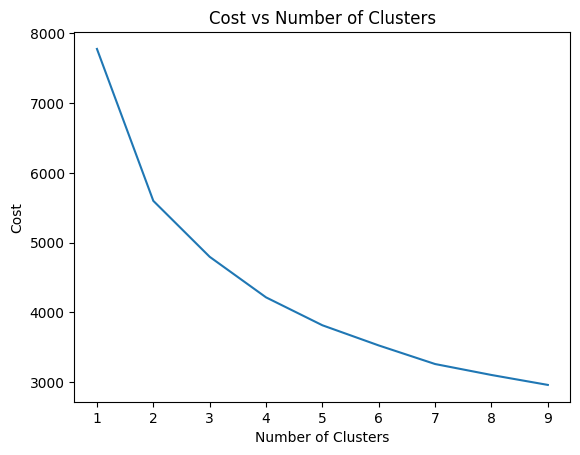

In [133]:
costs = []
n_clusters = []
clusters_assigned = []

for i in range(1,10):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(data_for_clustering_prototype, categorical=[1,2,5])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

plt.plot(n_clusters, costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Cost vs Number of Clusters')
plt.show()

In [134]:
categorical_columns = [1,2,5] 
kproto = KPrototypes(n_clusters= 3, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(data_for_clustering_prototype, categorical=categorical_columns)
pd.Series(clusters).value_counts()

2    415
1    375
0    186
Name: count, dtype: int64

In [135]:
#concatenate the cluster assignments to the original data
data_clustered = data.copy()
data_clustered['cluster'] = clusters
data_clustered.head()

,user_id,age,gender,location,income,credit_score,loan_type,loan_orig_dt,loan_orig_amt,number_of_installments,installment_amt,installments_paid,on_time_payments,late_payments,account_delq,cluster
2,3,23.0,male,Barranquilla,1.095391e+07,389,business,2024-07-15,3.128712e+07,31,1.009262e+06,0,0,0,False,2
3,4,27.0,female,Cartagena,1.203342e+07,488,personal,2022-10-17,1.958739e+06,27,7.254588e+04,20,17,3,False,0
4,5,18.0,male,Cartagena,1.859802e+07,350,business,2024-04-29,2.056685e+07,64,3.213570e+05,3,3,0,False,2
5,6,18.0,male,Bogota,4.263761e+07,386,business,2024-01-30,4.576458e+07,26,1.760176e+06,3,3,0,False,2
6,7,27.0,male,Barranquilla,2.545445e+07,357,auto,2022-12-20,1.634663e+07,43,3.801542e+05,17,15,2,False,2


### Visualizations

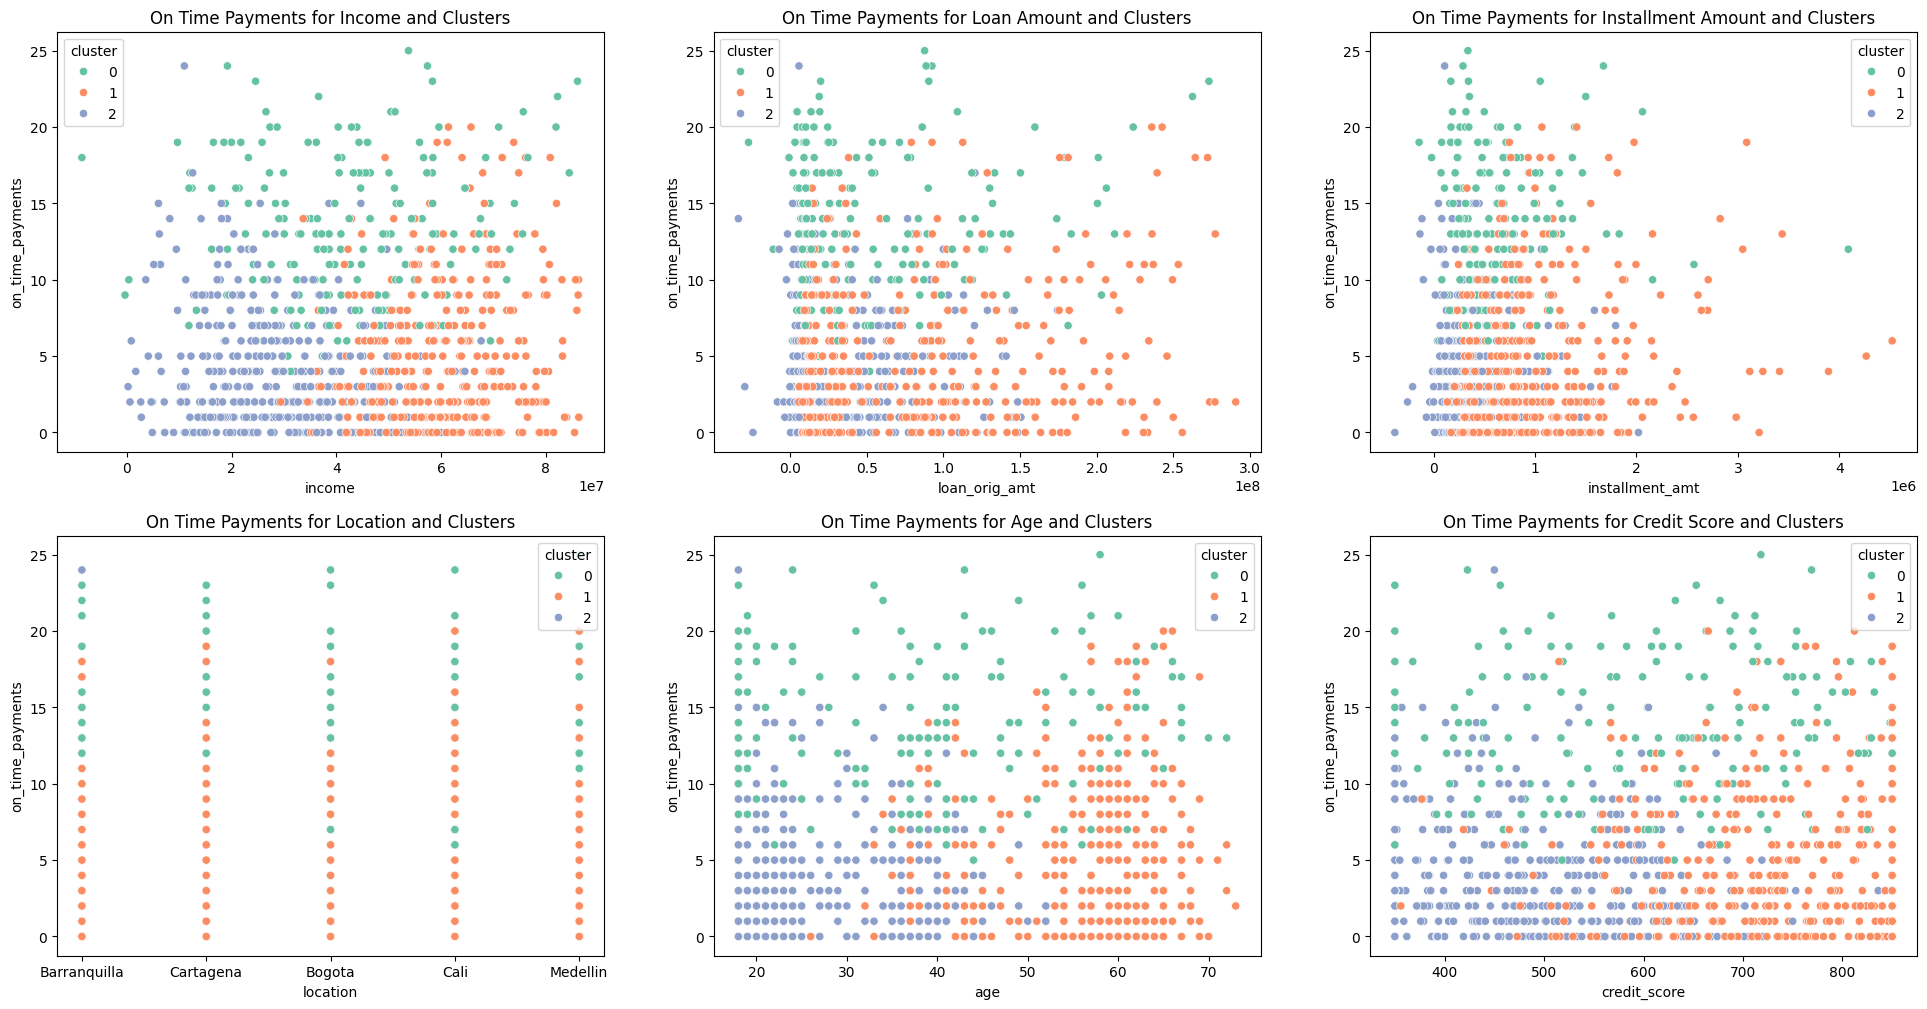

In [136]:
fig, ax = plt.subplots(2,3, figsize = (24,12))
_ =  sns.scatterplot(x ='income',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2', ax = ax[0,0])
_ =  sns.scatterplot(x ='loan_orig_amt',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2', ax = ax[0,1])
_ =  sns.scatterplot(x ='installment_amt',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2', ax = ax[0,2])
_ =  sns.scatterplot(x ='location',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2',ax= ax[1,0])
_ =  sns.scatterplot(x ='age',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2', ax= ax[1,1])
_ =  sns.scatterplot(x ='credit_score',y = 'on_time_payments', data = data_clustered, hue= 'cluster', palette = 'Set2', ax = ax[1,2])

_ = ax[0,0].set_title('On Time Payments for Income and Clusters')
_ = ax[0,1].set_title('On Time Payments for Loan Amount and Clusters')
_ = ax[0,2].set_title('On Time Payments for Installment Amount and Clusters')
_ = ax[1,0].set_title('On Time Payments for Location and Clusters')
_ = ax[1,1].set_title('On Time Payments for Age and Clusters')
_ = ax[1,2].set_title('On Time Payments for Credit Score and Clusters')

In [137]:
data_for_clustering_prototype.head()

,age,gender,location,income,credit_score,loan_type,loan_orig_amt,installment_amt,installments_paid,late_payments,account_delq
2,-1.027664,male,Barranquilla,-1.652721,-1.385388,business,-0.415392,0.525113,-1.115809,-0.855800,False
3,-0.785832,female,Cartagena,-1.597604,-0.727630,personal,-0.894083,-1.046739,1.745164,0.743296,False
4,-1.329955,male,Cartagena,-1.262427,-1.644505,business,-0.590366,-0.629222,-0.686663,-0.855800,False
5,-1.329955,male,Bogota,-0.035007,-1.405320,business,-0.179094,1.785181,-0.686663,-0.855800,False
6,-0.785832,male,Barranquilla,-0.912349,-1.597997,auto,-0.659247,-0.530558,1.316018,0.210264,False


In [138]:
#mean values for each cluster

#keep the cluster variales
df_analysis = data_clustered.copy()
df_analysis = df_analysis[['age', 'income', 'credit_score', 'loan_orig_amt', 'installment_amt', 'installments_paid', 'late_payments', 'cluster', 'gender', 'location', 'loan_type']]
#group by cluster and calculate the mean for numeric variables and mode for categorical variables
df_analysis = df_analysis.groupby('cluster').agg({'age': 'mean', 'income': 'mean', 'credit_score': 'mean', 'loan_orig_amt': 'mean', 
                                                  'installment_amt': 'mean', 'installments_paid': 'mean', 
                                                  'late_payments': 'mean'}).reset_index()

#format income, loan_orig_amt, and installment_amt to millions
df_analysis['income'] = df_analysis['income']/1000000
df_analysis['loan_orig_amt'] = df_analysis['loan_orig_amt']/1000000
df_analysis['installment_amt'] = df_analysis['installment_amt']/1000000
#format to 0 decimal places
df_analysis = df_analysis.round(0)
df_analysis

,cluster,age,income,credit_score,loan_orig_amt,installment_amt,installments_paid,late_payments
0,0,39.0,42.0,584.0,54.0,1.0,18.0,5.0
1,1,55.0,60.0,719.0,85.0,1.0,6.0,1.0
2,2,27.0,29.0,494.0,32.0,0.0,5.0,1.0


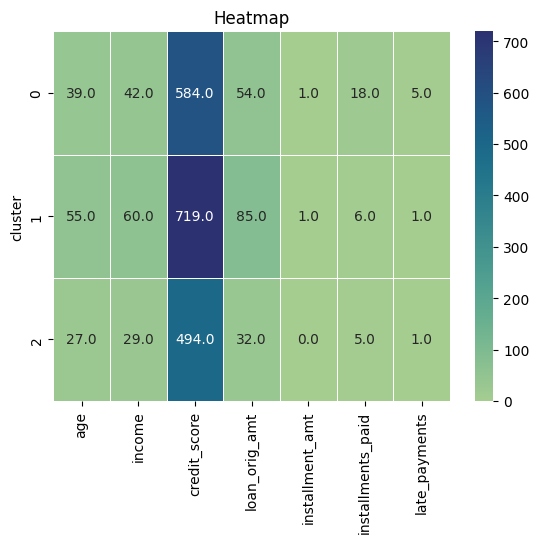

In [139]:
sns.heatmap(df_analysis.groupby('cluster').mean(), 
                annot=True,fmt=".1f", linewidth=.5, cmap="crest")
plt.title('Heatmap')
plt.show()